**Chapter 14 – Recurrent Neural Networks**

_This notebook contains all the sample code and solutions to the exercises in chapter 14._

# Setup

First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [3]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

Then of course we will need TensorFlow:

In [8]:
import tensorflow as tf

# Basic RNNs

 A recurrent neural network looks very much like a feedforward neural network, except it also has connections pointing backward. This is called unrolling the network through time.
 
 Each recurrent neuron has two sets of weights: one for the inputs x(t) and the other for the outputs of the previous time step, y(t–1). Let’s call these weight vectors wx and wy. 
 
 ### memory cell
 A part of a neural network that preserves some state across time steps is called a memory cell (or simply a cell).

## Manual RNN

In [3]:
reset_graph()

n_inputs = 3
n_neurons = 5

X0 = tf.placeholder(tf.float32, [None, n_inputs])
X1 = tf.placeholder(tf.float32, [None, n_inputs])

Wx = tf.Variable(tf.random_normal(shape=[n_inputs, n_neurons],dtype=tf.float32))
Wy = tf.Variable(tf.random_normal(shape=[n_neurons,n_neurons],dtype=tf.float32))
b = tf.Variable(tf.zeros([1, n_neurons], dtype=tf.float32))

Y0 = tf.tanh(tf.matmul(X0, Wx) + b)
Y1 = tf.tanh(tf.matmul(Y0, Wy) + tf.matmul(X1, Wx) + b)

init = tf.global_variables_initializer()

In [4]:
import numpy as np

X0_batch = np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 0, 1]]) # t = 0
X1_batch = np.array([[9, 8, 7], [0, 0, 0], [6, 5, 4], [3, 2, 1]]) # t = 1

with tf.Session() as sess:
    init.run()
    Y0_val, Y1_val = sess.run([Y0, Y1], feed_dict={X0: X0_batch, X1: X1_batch})

In [5]:
print(Y0_val)

[[-0.0664006   0.96257669  0.68105793  0.70918542 -0.89821601]
 [ 0.9977755  -0.71978903 -0.99657607  0.96739239 -0.99989718]
 [ 0.99999774 -0.99898803 -0.99999893  0.99677622 -0.99999988]
 [ 1.         -1.         -1.         -0.99818915  0.99950868]]


In [6]:
print(Y1_val)

[[ 1.         -1.         -1.          0.40200251 -0.99999982]
 [-0.12210421  0.62805271  0.96718431 -0.99371219 -0.25839362]
 [ 0.99999827 -0.9999994  -0.9999975  -0.85943311 -0.99998808]
 [ 0.99928284 -0.99999815 -0.99990582  0.98579627 -0.92205757]]


## Using `static_rnn()`

In [7]:
n_inputs = 3
n_neurons = 5

In [8]:
reset_graph()

X0 = tf.placeholder(tf.float32, [None, n_inputs])
X1 = tf.placeholder(tf.float32, [None, n_inputs])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
output_seqs, states = tf.contrib.rnn.static_rnn(basic_cell, [X0, X1],
                                                dtype=tf.float32)
Y0, Y1 = output_seqs

In [9]:
init = tf.global_variables_initializer()

In [10]:
X0_batch = np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 0, 1]])
X1_batch = np.array([[9, 8, 7], [0, 0, 0], [6, 5, 4], [3, 2, 1]])

with tf.Session() as sess:
    init.run()
    Y0_val, Y1_val = sess.run([Y0, Y1], feed_dict={X0: X0_batch, X1: X1_batch})

In [11]:
Y0_val

array([[ 0.30741334, -0.32884315, -0.65428472, -0.93850589,  0.52089024],
       [ 0.99122757, -0.95425421, -0.75180793, -0.99952078,  0.98202348],
       [ 0.99992681, -0.99783254, -0.82473528, -0.9999963 ,  0.99947774],
       [ 0.99677098, -0.68750614,  0.84199691,  0.93039107,  0.8120684 ]], dtype=float32)

In [12]:
Y1_val

array([[ 0.99998885, -0.99976051, -0.06679298, -0.99998039,  0.99982214],
       [-0.65249437, -0.51520866, -0.37968954, -0.59225935, -0.08968385],
       [ 0.99862403, -0.99715197, -0.03308626, -0.99915648,  0.99329019],
       [ 0.99681675, -0.95981938,  0.39660636, -0.83076048,  0.79671967]], dtype=float32)

In [15]:
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "b<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [16]:
show_graph(tf.get_default_graph())

## Packing sequences

In [39]:
n_steps = 2
n_inputs = 3
n_neurons = 5

In [40]:
reset_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
X_seqs = tf.unstack(tf.transpose(X, perm=[1, 0, 2]))

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
output_seqs, states = tf.contrib.rnn.static_rnn(basic_cell, X_seqs,
                                                dtype=tf.float32)
outputs = tf.transpose(tf.stack(output_seqs), perm=[1, 0, 2])

In [41]:
init = tf.global_variables_initializer()

In [42]:
X_batch = np.array([
        # t = 0      t = 1 
        [[0, 1, 2], [9, 8, 7]], # instance 1
        [[3, 4, 5], [0, 0, 0]], # instance 2
        [[6, 7, 8], [6, 5, 4]], # instance 3
        [[9, 0, 1], [3, 2, 1]], # instance 4
    ])

with tf.Session() as sess:
    init.run()
    outputs_val = outputs.eval(feed_dict={X: X_batch})

In [43]:
print(outputs_val)
outputs_val.shape

[[[-0.45652324 -0.68064123  0.40938237  0.63104504 -0.45732826]
  [-0.94288003 -0.99988687  0.94055814  0.99999851 -0.9999997 ]]

 [[-0.80015349 -0.99218267  0.78177971  0.9971031  -0.99646091]
  [-0.63711601  0.11300932  0.5798437   0.43105593 -0.63716984]]

 [[-0.93605185 -0.99983788  0.93088669  0.99998152 -0.99998295]
  [-0.9165386  -0.99456042  0.89605415  0.99987197 -0.99997509]]

 [[ 0.99273688 -0.99819332 -0.55543643  0.9989031  -0.9953323 ]
  [-0.02746334 -0.73191994  0.7827872   0.95256817 -0.97817713]]]


(4, 2, 5)

In [28]:
print(np.transpose(outputs_val, axes=[1, 0, 2])[1])

[[-0.94288003 -0.99988687  0.94055814  0.99999851 -0.9999997 ]
 [-0.63711601  0.11300932  0.5798437   0.43105593 -0.63716984]
 [-0.9165386  -0.99456042  0.89605415  0.99987197 -0.99997509]
 [-0.02746334 -0.73191994  0.7827872   0.95256817 -0.97817713]]


However, this approach still builds a graph containing one cell per time step. If there were 50 time steps, the graph would look pretty ugly.

Fortunately, there is a better solution: the dynamic_rnn() function.

## Using `dynamic_rnn()`

there is no need to stack, unstack, or transpose. 

In [33]:
n_steps = 2
n_inputs = 3
n_neurons = 5

In [34]:
reset_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

In [35]:
init = tf.global_variables_initializer()

In [36]:
X_batch = np.array([
        [[0, 1, 2], [9, 8, 7]], # instance 1
        [[3, 4, 5], [0, 0, 0]], # instance 2
        [[6, 7, 8], [6, 5, 4]], # instance 3
        [[9, 0, 1], [3, 2, 1]], # instance 4
    ])

with tf.Session() as sess:
    init.run()
    outputs_val = outputs.eval(feed_dict={X: X_batch})

In [44]:
print(outputs_val)

[[[-0.45652324 -0.68064123  0.40938237  0.63104504 -0.45732826]
  [-0.94288003 -0.99988687  0.94055814  0.99999851 -0.9999997 ]]

 [[-0.80015349 -0.99218267  0.78177971  0.9971031  -0.99646091]
  [-0.63711601  0.11300932  0.5798437   0.43105593 -0.63716984]]

 [[-0.93605185 -0.99983788  0.93088669  0.99998152 -0.99998295]
  [-0.9165386  -0.99456042  0.89605415  0.99987197 -0.99997509]]

 [[ 0.99273688 -0.99819332 -0.55543643  0.9989031  -0.9953323 ]
  [-0.02746334 -0.73191994  0.7827872   0.95256817 -0.97817713]]]


In [38]:
show_graph(tf.get_default_graph())

## Setting the sequence lengths

### Handling Variable Length Input Sequences
It must be padded with a zero vector in order to fit in the input tensor X 

In [74]:
n_steps = 2
n_inputs = 3
n_neurons = 5

reset_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)

In [75]:
seq_length = tf.placeholder(tf.int32, [None])
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32,
                                    sequence_length=seq_length)

In [77]:
init = tf.global_variables_initializer()

In [86]:
X_batch = np.array([
        # step 0     step 1
        [[0, 1, 2], [9, 8, 7]], # instance 1
        [[3, 4, 5], [0, 0, 0]], # instance 2 (padded with zero vectors)
        [[6, 7, 8], [6, 5, 4]], # instance 3
        [[9, 0, 1], [3, 2, 1]], # instance 4
    ])
seq_length_batch = np.array([2, 1, 2, 1])  # list of x size 

In [87]:
with tf.Session() as sess:
    init.run()
    outputs_val, states_val = sess.run(
        [outputs, states], feed_dict={X: X_batch, seq_length: seq_length_batch})

In [88]:
print(states_val)

[[-0.61832315  0.99999994  0.86584806  0.97933769  0.9902246 ]
 [ 0.8438704   0.99697548  0.84789461  0.4303219   0.09275495]
 [-0.77545464  0.99987745  0.97847283  0.73172009  0.888776  ]
 [-0.99952269  0.99977839  0.59744656  0.99309695  0.99847412]]


### Handling Variable-Length Output Sequences

the most common solution is to define a special output called an end-of-sequence token (EOS token). Any output past the EOS should be ignored (we will discuss this later in this chapter).
    

## Training a sequence classifier

To train an RNN, the trick is to unroll it through time (like we just did) and then simply use regular backpropagation (see Figure 14-5). This strategy is called backpropagation through time (`BPTT`).

Note that the gradients flow backward through all the outputs used by the cost function, not just through the final output 

Note: the book uses `tensorflow.contrib.layers.fully_connected()` rather than `tf.layers.dense()` (which did not exist when this chapter was written). It is now preferable to use `tf.layers.dense()`, because anything in the contrib module may change or be deleted without notice. The `dense()` function is almost identical to the `fully_connected()` function. The main differences relevant to this chapter are:
* several parameters are renamed: `scope` becomes `name`, `activation_fn` becomes `activation` (and similarly the `_fn` suffix is removed from other parameters such as `normalizer_fn`), `weights_initializer` becomes `kernel_initializer`, etc.
* the default `activation` is now `None` rather than `tf.nn.relu`.

In [89]:
reset_graph()

n_steps = 28
n_inputs = 28
n_neurons = 150
n_outputs = 10

learning_rate = 0.001

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

# Note that the fully connected layer is connected to the states tensor, 
# which contains only the final state of the RNN
logits = tf.layers.dense(states, n_outputs)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                          logits=logits)
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

In [90]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")
X_test = mnist.test.images.reshape((-1, n_steps, n_inputs))
y_test = mnist.test.labels

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [91]:
n_epochs = 100
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            X_batch = X_batch.reshape((-1, n_steps, n_inputs))
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)

0 Train accuracy: 0.946667 Test accuracy: 0.9366
1 Train accuracy: 0.966667 Test accuracy: 0.9488
2 Train accuracy: 0.96 Test accuracy: 0.9614
3 Train accuracy: 0.966667 Test accuracy: 0.9572
4 Train accuracy: 0.946667 Test accuracy: 0.9624
5 Train accuracy: 0.96 Test accuracy: 0.9634
6 Train accuracy: 0.973333 Test accuracy: 0.9714
7 Train accuracy: 0.98 Test accuracy: 0.9686
8 Train accuracy: 0.953333 Test accuracy: 0.9647
9 Train accuracy: 0.973333 Test accuracy: 0.9706
10 Train accuracy: 0.973333 Test accuracy: 0.9697
11 Train accuracy: 0.966667 Test accuracy: 0.9692
12 Train accuracy: 0.986667 Test accuracy: 0.9751
13 Train accuracy: 0.993333 Test accuracy: 0.9738
14 Train accuracy: 0.986667 Test accuracy: 0.9721
15 Train accuracy: 0.98 Test accuracy: 0.9752
16 Train accuracy: 0.993333 Test accuracy: 0.9779
17 Train accuracy: 0.98 Test accuracy: 0.976
18 Train accuracy: 0.986667 Test accuracy: 0.976
19 Train accuracy: 0.98 Test accuracy: 0.9709
20 Train accuracy: 0.986667 Test acc

# Multi-layer RNN

In [92]:
reset_graph()

n_steps = 28
n_inputs = 28
n_outputs = 10

learning_rate = 0.001

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

In [93]:
n_neurons = 100
n_layers = 3

layers = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons,
                                      activation=tf.nn.relu)
          for layer in range(n_layers)]
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

In [94]:
states_concat = tf.concat(axis=1, values=states)
logits = tf.layers.dense(states_concat, n_outputs)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

In [95]:
n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            X_batch = X_batch.reshape((-1, n_steps, n_inputs))
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)

0 Train accuracy: 0.946667 Test accuracy: 0.9495
1 Train accuracy: 0.973333 Test accuracy: 0.9625
2 Train accuracy: 0.953333 Test accuracy: 0.9648
3 Train accuracy: 0.986667 Test accuracy: 0.9761
4 Train accuracy: 0.993333 Test accuracy: 0.9719
5 Train accuracy: 0.993333 Test accuracy: 0.9739
6 Train accuracy: 0.98 Test accuracy: 0.9746
7 Train accuracy: 0.98 Test accuracy: 0.9782
8 Train accuracy: 0.986667 Test accuracy: 0.9768
9 Train accuracy: 0.986667 Test accuracy: 0.9769


# Time series

In [153]:
t_min, t_max = 0, 30
resolution = 0.1

def time_series(t):
    return t * np.sin(t) / 3 + 2 * np.sin(t*5)

def next_batch(batch_size, n_steps):
    t0 = np.random.rand(batch_size, 1) * (t_max - t_min - n_steps * resolution)
    Ts = t0 + np.arange(0., n_steps + 1) * resolution
    ys = time_series(Ts)
    return ys[:, :-1].reshape(-1, n_steps, 1), ys[:, 1:].reshape(-1, n_steps, 1)

Saving figure time_series_plot


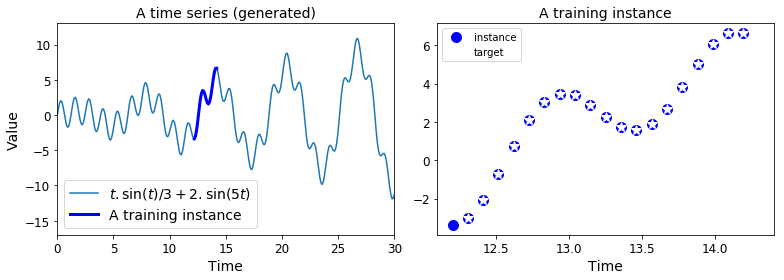

In [154]:
t = np.linspace(t_min, t_max, int((t_max - t_min) / resolution))

n_steps = 20
t_instance = np.linspace(12.2, 12.2 + resolution * (n_steps + 1), n_steps + 1)

plt.figure(figsize=(11,4))
plt.subplot(121)
plt.title("A time series (generated)", fontsize=14)
plt.plot(t, time_series(t), label=r"$t . \sin(t) / 3 + 2 . \sin(5t)$")
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "b-", linewidth=3, label="A training instance")
plt.legend(loc="lower left", fontsize=14)
plt.axis([0, 30, -17, 13])
plt.xlabel("Time")
plt.ylabel("Value")

plt.subplot(122)
plt.title("A training instance", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.legend(loc="upper left")
plt.xlabel("Time")


save_fig("time_series_plot")
plt.show()

In [155]:
X_batch, y_batch = next_batch(1, n_steps)

In [156]:
np.c_[X_batch[0], y_batch[0]]

array([[-2.84420859, -2.25797719],
       [-2.25797719, -1.55860615],
       [-1.55860615, -0.98486829],
       [-0.98486829, -0.74091726],
       [-0.74091726, -0.94556233],
       [-0.94556233, -1.60247334],
       [-1.60247334, -2.59861906],
       [-2.59861906, -3.73132895],
       [-3.73132895, -4.75736043],
       [-4.75736043, -5.45196489],
       [-5.45196489, -5.66349768],
       [-5.66349768, -5.35020711],
       [-5.35020711, -4.59020027],
       [-4.59020027, -3.56214977],
       [-3.56214977, -2.50146837],
       [-2.50146837, -1.64268375],
       [-1.64268375, -1.1621235 ],
       [-1.1621235 , -1.1349435 ],
       [-1.1349435 , -1.51701993],
       [-1.51701993, -2.15613685]])

## Using an `OuputProjectionWrapper`

Let's create the RNN. It will contain 100 recurrent neurons and we will unroll it over 20 time steps since each traiing instance will be 20 inputs long. Each input will contain only one feature (the value at that time). The targets are also sequences of 20 inputs, each containing a sigle value:

At each time step we now have an output vector of size 100. But what we actually want is a single output value at each time step. The simplest solution is to wrap the cell in an `OutputProjectionWrapper`.

## Without using an `OutputProjectionWrapper`

Although using an OutputProjectionWrapper is the simplest solution to reduce the dimensionality of the RNN’s output sequences down to just one value per time step (per instance), it is not the most efficient. There is a trickier but more efficient solution: you can reshape the RNN outputs from [batch_size, n_steps, n_neurons] to [batch_size * n_steps, n_neurons], then apply a single fully connected layer with the appropriate output size (in our case just 1), which will result in an output tensor of shape [batch_size * n_steps, n_outputs], and then reshape this tensor to [batch_size, n_steps, n_outputs]. 

The rest of the code is the same as earlier. This can provide a significant speed boost since there is just one fully connected layer instead of one per time step.

In [157]:
reset_graph()

n_neurons = 100
n_steps = 20
n_inputs = 1
n_outputs = 1
learning_rate = 0.001

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu)
rnn_outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons])
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])

loss = tf.reduce_mean(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [158]:
n_iterations = 1500
batch_size = 50

t_instance = np.linspace(12.2, 12.2 + resolution * (n_steps + 1), n_steps + 1)

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    
    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})
    
    saver.save(sess, "./my_time_series_model")

0 	MSE: 13.798524
100 	MSE: 0.5184861
200 	MSE: 0.18258934
300 	MSE: 0.084822476
400 	MSE: 0.062449113
500 	MSE: 0.060697965
600 	MSE: 0.055861413
700 	MSE: 0.050936103
800 	MSE: 0.05196387
900 	MSE: 0.05027977
1000 	MSE: 0.048902925
1100 	MSE: 0.05085831
1200 	MSE: 0.04179183
1300 	MSE: 0.048203375
1400 	MSE: 0.04349015


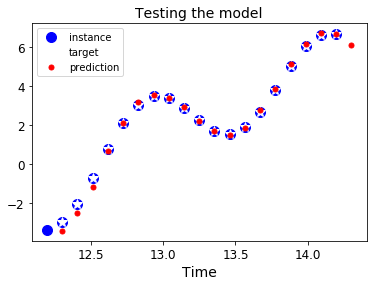

In [159]:
# y_pred
def show_predict(t_instance):
    plt.title("Testing the model", fontsize=14)
    plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
    plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
    plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
    plt.legend(loc="upper left")
    plt.xlabel("Time")

    plt.show()

show_predict(t_instance)

## Generating a creative new sequence

All we need is to provide it a seed sequence containing n_steps values (e.g., full of zeros), use the model to predict the next value, append this predicted value to the sequence, 


In [147]:
with tf.Session() as sess:                        # not shown in the book
    saver.restore(sess, "./my_time_series_model") # not shown

    sequence = [0.] * n_steps
    for iteration in range(300):
        X_batch = np.array(sequence[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence.append(y_pred[0, -1, 0])

INFO:tensorflow:Restoring parameters from ./my_time_series_model


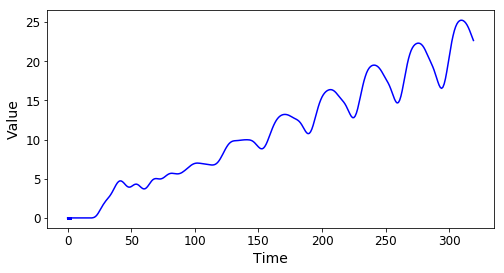

In [148]:
plt.figure(figsize=(8,4))
plt.plot(np.arange(len(sequence)), sequence, "b-")
plt.plot(t[:n_steps], sequence[:n_steps], "b-", linewidth=3)
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()

INFO:tensorflow:Restoring parameters from ./my_time_series_model
Saving figure creative_sequence_plot


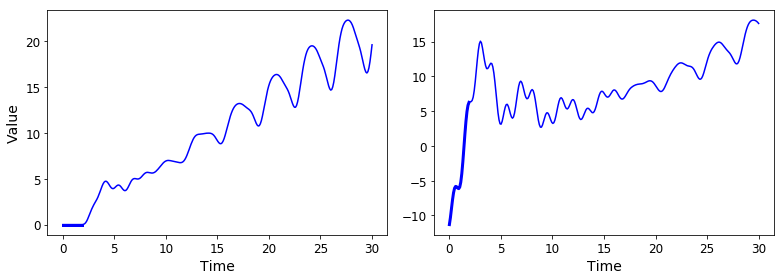

In [149]:
with tf.Session() as sess:
    saver.restore(sess, "./my_time_series_model")

    sequence1 = [0. for i in range(n_steps)]
    for iteration in range(len(t) - n_steps):
        X_batch = np.array(sequence1[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence1.append(y_pred[0, -1, 0])

    sequence2 = [time_series(i * resolution + t_min + (t_max-t_min/3)) for i in range(n_steps)]
    for iteration in range(len(t) - n_steps):
        X_batch = np.array(sequence2[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence2.append(y_pred[0, -1, 0])

plt.figure(figsize=(11,4))
plt.subplot(121)
plt.plot(t, sequence1, "b-")
plt.plot(t[:n_steps], sequence1[:n_steps], "b-", linewidth=3)
plt.xlabel("Time")
plt.ylabel("Value")

plt.subplot(122)
plt.plot(t, sequence2, "b-")
plt.plot(t[:n_steps], sequence2[:n_steps], "b-", linewidth=3)
plt.xlabel("Time")
save_fig("creative_sequence_plot")
plt.show()

# Deep RNN

## MultiRNNCell

In [150]:
reset_graph()

n_inputs = 2
n_steps = 5

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])

In [151]:
n_neurons = 100
n_layers = 3

layers = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
          for layer in range(n_layers)]
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

In [152]:
init = tf.global_variables_initializer()

In [153]:
X_batch = np.random.rand(2, n_steps, n_inputs)

In [154]:
with tf.Session() as sess:
    init.run()
    outputs_val, states_val = sess.run([outputs, states], feed_dict={X: X_batch})

In [157]:
outputs_val.shape

(2, 5, 100)

## Distributing a Deep RNN Across Multiple GPUs

Do **NOT** do this:

In [72]:
with tf.device("/gpu:0"):  # BAD! This is ignored.
    layer1 = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)

with tf.device("/gpu:1"):  # BAD! Ignored again.
    layer2 = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)

Instead, you need a `DeviceCellWrapper`:

In [73]:
import tensorflow as tf

class DeviceCellWrapper(tf.contrib.rnn.RNNCell):
  def __init__(self, device, cell):
    self._cell = cell
    self._device = device

  @property
  def state_size(self):
    return self._cell.state_size

  @property
  def output_size(self):
    return self._cell.output_size

  def __call__(self, inputs, state, scope=None):
    with tf.device(self._device):
        return self._cell(inputs, state, scope)

In [74]:
reset_graph()

n_inputs = 5
n_steps = 20
n_neurons = 100

X = tf.placeholder(tf.float32, shape=[None, n_steps, n_inputs])

In [75]:
devices = ["/cpu:0", "/cpu:0", "/cpu:0"] # replace with ["/gpu:0", "/gpu:1", "/gpu:2"] if you have 3 GPUs
cells = [DeviceCellWrapper(dev,tf.contrib.rnn.BasicRNNCell(num_units=n_neurons))
         for dev in devices]
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(cells)
outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

In [76]:
init = tf.global_variables_initializer()

In [77]:
with tf.Session() as sess:
    init.run()
    print(sess.run(outputs, feed_dict={X: np.random.rand(2, n_steps, n_inputs)}))

[[[-0.06683909 -0.06814943  0.12806301 ..., -0.04951219  0.0169118
    0.09129722]
  [-0.03898398 -0.32816607  0.25709429 ..., -0.22360352 -0.00203764
    0.18901907]
  [-0.14598769 -0.03324183  0.06588719 ..., -0.36336255 -0.117153
    0.39544109]
  ..., 
  [-0.52596134  0.04002573  0.14033252 ...,  0.18522167  0.25101244
   -0.05308188]
  [-0.45618156 -0.11686647 -0.09905577 ..., -0.17943858  0.27567461
   -0.04363405]
  [-0.55723065  0.13874871 -0.14983818 ...,  0.04673974  0.10338999
   -0.03823486]]

 [[-0.0191099  -0.06458578  0.08206855 ..., -0.07772326 -0.05498064
    0.01358664]
  [-0.05150904 -0.36381066  0.0913103  ..., -0.12480559 -0.03924585
    0.06585156]
  [-0.29961377 -0.00120922  0.06789977 ..., -0.27556923 -0.15278165
    0.21452278]
  ..., 
  [-0.6460501   0.17479922  0.14066698 ..., -0.08995064 -0.03049678
    0.05738082]
  [-0.61097401 -0.17900243 -0.23193845 ..., -0.2500132   0.25146627
    0.36902413]
  [-0.25920284 -0.08149087  0.19740498 ..., -0.32611009 -0.02

## Dropout

Unfortunately, this code is only usable for training, because the `DropoutWrapper` class has no `training` parameter, so it always applies dropout, even when the model is not being trained, so we must first train the model, then create a different model for testing, without the `DropoutWrapper`.

In [172]:
n_inputs = 1
n_neurons = 100
n_layers = 3
n_steps = 20
n_outputs = 1

Another option is to write a script with a command line argument to specify whether you want to train the mode or use it for making predictions:

In [175]:
reset_graph()

import sys
training = False  # in a script, this would be (sys.argv[-1] == "train") instead

n_iterations = 1000
batch_size = 50

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

cells = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
         for layer in range(n_layers)]
if training:
    cells = [tf.contrib.rnn.DropoutWrapper(cell, input_keep_prob=keep_prob)
             for cell in cells]
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(cells)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons])    # not shown in the book
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs) # not shown
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])   # not shown
loss = tf.reduce_mean(tf.square(outputs - y))                     # not shown
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)   # not shown
training_op = optimizer.minimize(loss)                            # not shown
init = tf.global_variables_initializer()                          # not shown
saver = tf.train.Saver()                                          # not shown

with tf.Session() as sess:
    if training:
        init.run()
        for iteration in range(n_iterations):
            X_batch, y_batch = next_batch(batch_size, n_steps)    # not shown
            _, mse = sess.run([training_op, loss], feed_dict={X: X_batch, y: y_batch}) # not shown
            if iteration % 100 == 0:                              # not shown
                print(iteration, "Training MSE:", mse)            # not shown
        save_path = saver.save(sess, "/tmp/my_model.ckpt")
    else:
        saver.restore(sess, "/tmp/my_model.ckpt")
        X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs))) # not shown
        y_pred = sess.run(outputs, feed_dict={X: X_new})                              # not shown

INFO:tensorflow:Restoring parameters from /tmp/my_model.ckpt


INFO:tensorflow:Restoring parameters from ./my_dropout_time_series_model


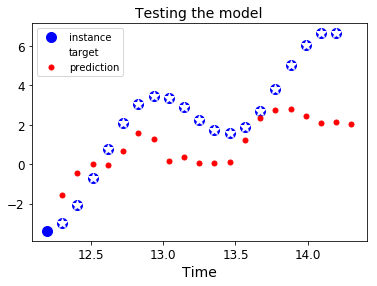

In [176]:
with tf.Session() as sess:
    saver.restore(sess, "./my_dropout_time_series_model")

    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})

plt.title("Testing the model", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")

plt.show()

Oops, it seems that Dropout does not help at all in this particular case. :/

# LSTM

In [177]:
reset_graph()

lstm_cell = tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons)

In [178]:
n_steps = 28
n_inputs = 28
n_neurons = 150
n_outputs = 10
n_layers = 3

learning_rate = 0.001

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

lstm_cells = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons)
              for layer in range(n_layers)]
multi_cell = tf.contrib.rnn.MultiRNNCell(lstm_cells)
outputs, states = tf.nn.dynamic_rnn(multi_cell, X, dtype=tf.float32)
top_layer_h_state = states[-1][1]
logits = tf.layers.dense(top_layer_h_state, n_outputs, name="softmax")
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()

In [179]:
states

(LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_2:0' shape=(?, 150) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_3:0' shape=(?, 150) dtype=float32>),
 LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_4:0' shape=(?, 150) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_5:0' shape=(?, 150) dtype=float32>),
 LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_6:0' shape=(?, 150) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_7:0' shape=(?, 150) dtype=float32>))

In [88]:
top_layer_h_state

<tf.Tensor 'rnn/while/Exit_7:0' shape=(?, 150) dtype=float32>

In [180]:
n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            X_batch = X_batch.reshape((batch_size, n_steps, n_inputs))
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print("Epoch", epoch, "Train accuracy =", acc_train, "Test accuracy =", acc_test)

Epoch 0 Train accuracy = 0.933333 Test accuracy = 0.9505
Epoch 1 Train accuracy = 0.973333 Test accuracy = 0.9711
Epoch 2 Train accuracy = 0.993333 Test accuracy = 0.9751
Epoch 3 Train accuracy = 1.0 Test accuracy = 0.9772
Epoch 4 Train accuracy = 0.98 Test accuracy = 0.9799
Epoch 5 Train accuracy = 0.98 Test accuracy = 0.9841
Epoch 6 Train accuracy = 0.993333 Test accuracy = 0.9836
Epoch 7 Train accuracy = 1.0 Test accuracy = 0.9867
Epoch 8 Train accuracy = 1.0 Test accuracy = 0.9866
Epoch 9 Train accuracy = 1.0 Test accuracy = 0.9879


## peephole connections: 
    the previous long-term state c(t–1) is added as an input to the controllers of the forget gate and the input gate, and the current long-term state c(t) is added as input to the controller of the output gate.

In [90]:
lstm_cell = tf.contrib.rnn.LSTMCell(num_units=n_neurons, use_peepholes=True)

## GRU cell

The GRU cell is a simplified version of the LSTM cell, and it seems to perform just as well

In [91]:
gru_cell = tf.contrib.rnn.GRUCell(num_units=n_neurons)

# Embeddings

This section is based on TensorFlow's [Word2Vec tutorial](https://www.tensorflow.org/versions/r0.11/tutorials/word2vec/index.html).

 In practice we approximate the expectation by drawing k contrastive words from the noise distribution
 
 This objective is maximized when the model assigns high probabilities to the real words, and low probabilities to noise words. Technically, this is called Negative Sampling,
 
computing the loss function now scales only with the number of noise words that we select (k), and not all words in the vocabulary (V). This makes it much faster to train. 

 that skip-gram inverts contexts and targets, and tries to predict each context word from its target word, so the task becomes to predict 'the' and 'brown' from 'quick', 'quick' and 'fox' from 'brown', etc. 

## Fetch the data

In [183]:
from six.moves import urllib

import errno
import os
import zipfile

WORDS_PATH = "datasets/words"
WORDS_URL = 'http://mattmahoney.net/dc/text8.zip'

def mkdir_p(path):
    """Create directories, ok if they already exist.
    
    This is for python 2 support. In python >=3.2, simply use:
    >>> os.makedirs(path, exist_ok=True)
    """
    try:
        os.makedirs(path)
    except OSError as exc:
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise

def fetch_words_data(words_url=WORDS_URL, words_path=WORDS_PATH):
    os.makedirs(words_path)
    zip_path = os.path.join(words_path, "words.zip")
    if not os.path.exists(zip_path):
        urllib.request.urlretrieve(words_url, zip_path)
    with zipfile.ZipFile(zip_path) as f:
        data = f.read(f.namelist()[0])
    return data.decode("ascii").split()

In [184]:
words = fetch_words_data()

In [185]:
words[:5]

[u'anarchism', u'originated', u'as', u'a', u'term']

## Build the dictionary

In [186]:
from collections import Counter

vocabulary_size = 50000
# build vocabulary with limit size
vocabulary = [("UNK", None)] + Counter(words).most_common(vocabulary_size - 1)
vocabulary = np.array([word for word, _ in vocabulary])
# {word: id}
dictionary = {word: code for code, word in enumerate(vocabulary)}
data = np.array([dictionary.get(word, 0) for word in words])

In [189]:
" ".join(words[:9]), data[:9]

(u'anarchism originated as a term of abuse first used',
 array([5239, 3084,   12,    6,  195,    2, 3137,   46,   59]))

In [252]:
' '.join([vocabulary[i] for i in data[:10]])

u'anarchism originated as a term of abuse first used against'

## Generate batches

In [302]:
def show_gram(lst):
    print(' '.join([vocabulary[i] for i in lst]))

In [325]:
import random
from collections import deque

def generate_batch(batch_size, num_skips, skip_window):
    """
    These batches will consist of input words (stored in batch) and random associated context 
    words within the gram as the labels to predict (stored in context). 
    
    num_skips: the number of words drawn randomly from the surrounding context
    skip_window: the size of the window of context words to draw from around the input word 
    """
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    context = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1 # [ skip_window target skip_window ]
    # Whenever a new word index is added to the buffer, the left most element 
    # will drop out of the buffer to allow room for the new word index being added. 
    buffer = deque(maxlen=span)
    show_gram(buffer)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    for i in range(batch_size // num_skips):
        target = skip_window  # target label at the center of the buffer
        targets_to_avoid = [ skip_window ]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            # set batch by index
            batch[i * num_skips + j] = buffer[skip_window]  # this is the input word
            context[i * num_skips + j, 0] = buffer[target]  # these are the context words
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, context

In [327]:
data_index=0
batch, labels = generate_batch(8, 2, 1)
show_gram(data[:8])
show_gram(batch)
show_gram(labels[:,0])


anarchism originated as a term of abuse first
as as a a term term of of
originated a of originated abuse a term abuse


## Build the model

In [328]:
batch_size = 128
embedding_size = 128  # Dimension of the embedding vector.
skip_window = 1       # How many words to consider left and right.
num_skips = 2         # How many times to reuse an input to generate a label.

# We pick a random validation set to sample nearest neighbors. Here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent.
valid_size = 16     # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)
num_sampled = 64    # Number of negative examples to sample.

learning_rate = 0.01

In [338]:
valid_examples

array([83, 53, 70, 45, 44, 39, 22, 80, 10,  0, 18, 30, 73, 33, 90,  4])

In [330]:
reset_graph()

# Input data.
train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

In [331]:
vocabulary_size = 50000
embedding_size = 150

# Look up embeddings for inputs.
init_embeds = tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0)
embeddings = tf.Variable(init_embeds)

In [332]:
train_inputs = tf.placeholder(tf.int32, shape=[None])
embed = tf.nn.embedding_lookup(embeddings, train_inputs)

In [333]:
# Construct the variables for the NCE loss
nce_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                        stddev=1.0 / np.sqrt(embedding_size)))
nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

# Compute the average NCE(Noise-contrastive estimation) loss for the batch.
# tf.nce_loss automatically draws a new sample of the negative labels each
# time we evaluate the loss.
loss = tf.reduce_mean(
    tf.nn.nce_loss(nce_weights, nce_biases, train_labels, embed,
                   num_sampled, vocabulary_size))

# Construct the Adam optimizer
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

# Compute the cosine similarity between minibatch examples and all embeddings.
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), axis=1, keep_dims=True))
normalized_embeddings = embeddings / norm
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)

# Add variable initializer.
init = tf.global_variables_initializer()

## Train the model

In [369]:
#tf.nn.embedding_lookup?
normalized_embeddings, valid_embeddings, similarity
final_embeddings.shape

(50000, 150)

In [336]:
num_steps = 10001

with tf.Session() as session:
    init.run()

    average_loss = 0
    for step in range(num_steps):
        print("\rIteration: {}".format(step), end="\t")
        batch_inputs, batch_labels = generate_batch(batch_size, num_skips, skip_window)
        feed_dict = {train_inputs : batch_inputs, train_labels : batch_labels}

        # We perform one update step by evaluating the training op (including it
        # in the list of returned values for session.run()
        _, loss_val = session.run([training_op, loss], feed_dict=feed_dict)
        average_loss += loss_val

        if step % 2000 == 0:
            if step > 0:
                average_loss /= 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
            print("Average loss at step ", step, ": ", average_loss)
            average_loss = 0

        # Note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = vocabulary[valid_examples[i]]
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log_str = "Nearest to %s:" % valid_word
                for k in range(top_k):
                    close_word = vocabulary[nearest[k]]
                    log_str = "%s %s," % (log_str, close_word)
                print(log_str)

    final_embeddings = normalized_embeddings.eval()

Iteration: 0	
Average loss at step  0 :  285.792297363
Nearest to people: keane, consumption, yag, alhazred, spill, persians, constitutionality, prodigal,
Nearest to can: connie, ptolemaic, thermochemistry, spamalot, leverett, michael, inherit, fiasco,
Nearest to than: fiery, reunification, receives, marquise, divides, picatinny, sliced, octane,
Nearest to its: belew, kovacs, tully, pup, boasian, iana, mechanosynthesis, cold,
Nearest to their: horizonte, basal, ray, verbose, aversion, prowess, prudence, fairchild,
Nearest to have: might, slough, bitrate, beale, commercialism, sponges, suzaku, ascorbic,
Nearest to six: interpolating, batavia, madhu, chiuchow, doubling, halves, amer, mordecai,
Nearest to over: kazaa, pregnant, vcjd, detecting, cambridge, preset, hindered, mica,
Nearest to two: unaltered, shimbun, flocked, liberator, ogden, team, psychiatrist, instinctively,
Nearest to UNK: rai, fi, gonzales, affirm, chekhov, correspond, correspondance, cir,
Nearest to was: penetrated, mu

Iteration: 426	
Iteration: 427	
Iteration: 428	
Iteration: 429	
Iteration: 430	
Iteration: 431	
Iteration: 432	
Iteration: 433	
Iteration: 434	
Iteration: 435	
Iteration: 436	
Iteration: 437	
Iteration: 438	
Iteration: 439	
Iteration: 440	
Iteration: 441	
Iteration: 442	
Iteration: 443	
Iteration: 444	
Iteration: 445	
Iteration: 446	
Iteration: 447	
Iteration: 448	
Iteration: 449	
Iteration: 450	
Iteration: 451	
Iteration: 452	
Iteration: 453	
Iteration: 454	
Iteration: 455	
Iteration: 456	
Iteration: 457	
Iteration: 458	
Iteration: 459	
Iteration: 460	
Iteration: 461	
Iteration: 462	
Iteration: 463	
Iteration: 464	
Iteration: 465	
Iteration: 466	
Iteration: 467	
Iteration: 468	
Iteration: 469	
Iteration: 470	
Iteration: 471	
Iteration: 472	
Iteration: 473	
Iteration: 474	
Iteration: 475	
Iteration: 476	
Iteration: 477	
Iteration: 478	
Iteration: 479	
Iteration: 480	
Iteration: 481	
Iteration: 482	
Iteration: 483	
Iteration: 484	
Iteration: 485	
Iteration: 486	
Iteration: 487	
Iteratio

Iteration: 940	
Iteration: 941	
Iteration: 942	
Iteration: 943	
Iteration: 944	
Iteration: 945	
Iteration: 946	
Iteration: 947	
Iteration: 948	
Iteration: 949	
Iteration: 950	
Iteration: 951	
Iteration: 952	
Iteration: 953	
Iteration: 954	
Iteration: 955	
Iteration: 956	
Iteration: 957	
Iteration: 958	
Iteration: 959	
Iteration: 960	
Iteration: 961	
Iteration: 962	
Iteration: 963	
Iteration: 964	
Iteration: 965	
Iteration: 966	
Iteration: 967	
Iteration: 968	
Iteration: 969	
Iteration: 970	
Iteration: 971	
Iteration: 972	
Iteration: 973	
Iteration: 974	
Iteration: 975	
Iteration: 976	
Iteration: 977	
Iteration: 978	
Iteration: 979	
Iteration: 980	
Iteration: 981	
Iteration: 982	
Iteration: 983	
Iteration: 984	
Iteration: 985	
Iteration: 986	
Iteration: 987	
Iteration: 988	
Iteration: 989	
Iteration: 990	
Iteration: 991	
Iteration: 992	
Iteration: 993	
Iteration: 994	
Iteration: 995	
Iteration: 996	
Iteration: 997	
Iteration: 998	
Iteration: 999	
Iteration: 1000	
Iteration: 1001	
Iterat

Iteration: 1427	
Iteration: 1428	
Iteration: 1429	
Iteration: 1430	
Iteration: 1431	
Iteration: 1432	
Iteration: 1433	
Iteration: 1434	
Iteration: 1435	
Iteration: 1436	
Iteration: 1437	
Iteration: 1438	
Iteration: 1439	
Iteration: 1440	
Iteration: 1441	
Iteration: 1442	
Iteration: 1443	
Iteration: 1444	
Iteration: 1445	
Iteration: 1446	
Iteration: 1447	
Iteration: 1448	
Iteration: 1449	
Iteration: 1450	
Iteration: 1451	
Iteration: 1452	
Iteration: 1453	
Iteration: 1454	
Iteration: 1455	
Iteration: 1456	
Iteration: 1457	
Iteration: 1458	
Iteration: 1459	
Iteration: 1460	
Iteration: 1461	
Iteration: 1462	
Iteration: 1463	
Iteration: 1464	
Iteration: 1465	
Iteration: 1466	
Iteration: 1467	
Iteration: 1468	
Iteration: 1469	
Iteration: 1470	
Iteration: 1471	
Iteration: 1472	
Iteration: 1473	
Iteration: 1474	
Iteration: 1475	
Iteration: 1476	
Iteration: 1477	
Iteration: 1478	
Iteration: 1479	
Iteration: 1480	
Iteration: 1481	
Iteration: 1482	
Iteration: 1483	
Iteration: 1484	
Iteration: 148

Iteration: 1909	
Iteration: 1910	
Iteration: 1911	
Iteration: 1912	
Iteration: 1913	
Iteration: 1914	
Iteration: 1915	
Iteration: 1916	
Iteration: 1917	
Iteration: 1918	
Iteration: 1919	
Iteration: 1920	
Iteration: 1921	
Iteration: 1922	
Iteration: 1923	
Iteration: 1924	
Iteration: 1925	
Iteration: 1926	
Iteration: 1927	
Iteration: 1928	
Iteration: 1929	
Iteration: 1930	
Iteration: 1931	
Iteration: 1932	
Iteration: 1933	
Iteration: 1934	
Iteration: 1935	
Iteration: 1936	
Iteration: 1937	
Iteration: 1938	
Iteration: 1939	
Iteration: 1940	
Iteration: 1941	
Iteration: 1942	
Iteration: 1943	
Iteration: 1944	
Iteration: 1945	
Iteration: 1946	
Iteration: 1947	
Iteration: 1948	
Iteration: 1949	
Iteration: 1950	
Iteration: 1951	
Iteration: 1952	
Iteration: 1953	
Iteration: 1954	
Iteration: 1955	
Iteration: 1956	
Iteration: 1957	
Iteration: 1958	
Iteration: 1959	
Iteration: 1960	
Iteration: 1961	
Iteration: 1962	
Iteration: 1963	
Iteration: 1964	
Iteration: 1965	
Iteration: 1966	
Iteration: 196

Iteration: 2389	
Iteration: 2390	
Iteration: 2391	
Iteration: 2392	
Iteration: 2393	
Iteration: 2394	
Iteration: 2395	
Iteration: 2396	
Iteration: 2397	
Iteration: 2398	
Iteration: 2399	
Iteration: 2400	
Iteration: 2401	
Iteration: 2402	
Iteration: 2403	
Iteration: 2404	
Iteration: 2405	
Iteration: 2406	
Iteration: 2407	
Iteration: 2408	
Iteration: 2409	
Iteration: 2410	
Iteration: 2411	
Iteration: 2412	
Iteration: 2413	
Iteration: 2414	
Iteration: 2415	
Iteration: 2416	
Iteration: 2417	
Iteration: 2418	
Iteration: 2419	
Iteration: 2420	
Iteration: 2421	
Iteration: 2422	
Iteration: 2423	
Iteration: 2424	
Iteration: 2425	
Iteration: 2426	
Iteration: 2427	
Iteration: 2428	
Iteration: 2429	
Iteration: 2430	
Iteration: 2431	
Iteration: 2432	
Iteration: 2433	
Iteration: 2434	
Iteration: 2435	
Iteration: 2436	
Iteration: 2437	
Iteration: 2438	
Iteration: 2439	
Iteration: 2440	
Iteration: 2441	
Iteration: 2442	
Iteration: 2443	
Iteration: 2444	
Iteration: 2445	
Iteration: 2446	
Iteration: 244

Iteration: 2871	
Iteration: 2872	
Iteration: 2873	
Iteration: 2874	
Iteration: 2875	
Iteration: 2876	
Iteration: 2877	
Iteration: 2878	
Iteration: 2879	
Iteration: 2880	
Iteration: 2881	
Iteration: 2882	
Iteration: 2883	
Iteration: 2884	
Iteration: 2885	
Iteration: 2886	
Iteration: 2887	
Iteration: 2888	
Iteration: 2889	
Iteration: 2890	
Iteration: 2891	
Iteration: 2892	
Iteration: 2893	
Iteration: 2894	
Iteration: 2895	
Iteration: 2896	
Iteration: 2897	
Iteration: 2898	
Iteration: 2899	
Iteration: 2900	
Iteration: 2901	
Iteration: 2902	
Iteration: 2903	
Iteration: 2904	
Iteration: 2905	
Iteration: 2906	
Iteration: 2907	
Iteration: 2908	
Iteration: 2909	
Iteration: 2910	
Iteration: 2911	
Iteration: 2912	
Iteration: 2913	
Iteration: 2914	
Iteration: 2915	
Iteration: 2916	
Iteration: 2917	
Iteration: 2918	
Iteration: 2919	
Iteration: 2920	
Iteration: 2921	
Iteration: 2922	
Iteration: 2923	
Iteration: 2924	
Iteration: 2925	
Iteration: 2926	
Iteration: 2927	
Iteration: 2928	
Iteration: 292

Iteration: 3353	
Iteration: 3354	
Iteration: 3355	
Iteration: 3356	
Iteration: 3357	
Iteration: 3358	
Iteration: 3359	
Iteration: 3360	
Iteration: 3361	
Iteration: 3362	
Iteration: 3363	
Iteration: 3364	
Iteration: 3365	
Iteration: 3366	
Iteration: 3367	
Iteration: 3368	
Iteration: 3369	
Iteration: 3370	
Iteration: 3371	
Iteration: 3372	
Iteration: 3373	
Iteration: 3374	
Iteration: 3375	
Iteration: 3376	
Iteration: 3377	
Iteration: 3378	
Iteration: 3379	
Iteration: 3380	
Iteration: 3381	
Iteration: 3382	
Iteration: 3383	
Iteration: 3384	
Iteration: 3385	
Iteration: 3386	
Iteration: 3387	
Iteration: 3388	
Iteration: 3389	
Iteration: 3390	
Iteration: 3391	
Iteration: 3392	
Iteration: 3393	
Iteration: 3394	
Iteration: 3395	
Iteration: 3396	
Iteration: 3397	
Iteration: 3398	
Iteration: 3399	
Iteration: 3400	
Iteration: 3401	
Iteration: 3402	
Iteration: 3403	
Iteration: 3404	
Iteration: 3405	
Iteration: 3406	
Iteration: 3407	
Iteration: 3408	
Iteration: 3409	
Iteration: 3410	
Iteration: 341

Iteration: 3836	
Iteration: 3837	
Iteration: 3838	
Iteration: 3839	
Iteration: 3840	
Iteration: 3841	
Iteration: 3842	
Iteration: 3843	
Iteration: 3844	
Iteration: 3845	
Iteration: 3846	
Iteration: 3847	
Iteration: 3848	
Iteration: 3849	
Iteration: 3850	
Iteration: 3851	
Iteration: 3852	
Iteration: 3853	
Iteration: 3854	
Iteration: 3855	
Iteration: 3856	
Iteration: 3857	
Iteration: 3858	
Iteration: 3859	
Iteration: 3860	
Iteration: 3861	
Iteration: 3862	
Iteration: 3863	
Iteration: 3864	
Iteration: 3865	
Iteration: 3866	
Iteration: 3867	
Iteration: 3868	
Iteration: 3869	
Iteration: 3870	
Iteration: 3871	
Iteration: 3872	
Iteration: 3873	
Iteration: 3874	
Iteration: 3875	
Iteration: 3876	
Iteration: 3877	
Iteration: 3878	
Iteration: 3879	
Iteration: 3880	
Iteration: 3881	
Iteration: 3882	
Iteration: 3883	
Iteration: 3884	
Iteration: 3885	
Iteration: 3886	
Iteration: 3887	
Iteration: 3888	
Iteration: 3889	
Iteration: 3890	
Iteration: 3891	
Iteration: 3892	
Iteration: 3893	
Iteration: 389

Iteration: 4317	
Iteration: 4318	
Iteration: 4319	
Iteration: 4320	
Iteration: 4321	
Iteration: 4322	
Iteration: 4323	
Iteration: 4324	
Iteration: 4325	
Iteration: 4326	
Iteration: 4327	
Iteration: 4328	
Iteration: 4329	
Iteration: 4330	
Iteration: 4331	
Iteration: 4332	
Iteration: 4333	
Iteration: 4334	
Iteration: 4335	
Iteration: 4336	
Iteration: 4337	
Iteration: 4338	
Iteration: 4339	
Iteration: 4340	
Iteration: 4341	
Iteration: 4342	
Iteration: 4343	
Iteration: 4344	
Iteration: 4345	
Iteration: 4346	
Iteration: 4347	
Iteration: 4348	
Iteration: 4349	
Iteration: 4350	
Iteration: 4351	
Iteration: 4352	
Iteration: 4353	
Iteration: 4354	
Iteration: 4355	
Iteration: 4356	
Iteration: 4357	
Iteration: 4358	
Iteration: 4359	
Iteration: 4360	
Iteration: 4361	
Iteration: 4362	
Iteration: 4363	
Iteration: 4364	
Iteration: 4365	
Iteration: 4366	
Iteration: 4367	
Iteration: 4368	
Iteration: 4369	
Iteration: 4370	
Iteration: 4371	
Iteration: 4372	
Iteration: 4373	
Iteration: 4374	
Iteration: 437

Iteration: 4800	
Iteration: 4801	
Iteration: 4802	
Iteration: 4803	
Iteration: 4804	
Iteration: 4805	
Iteration: 4806	
Iteration: 4807	
Iteration: 4808	
Iteration: 4809	
Iteration: 4810	
Iteration: 4811	
Iteration: 4812	
Iteration: 4813	
Iteration: 4814	
Iteration: 4815	
Iteration: 4816	
Iteration: 4817	
Iteration: 4818	
Iteration: 4819	
Iteration: 4820	
Iteration: 4821	
Iteration: 4822	
Iteration: 4823	
Iteration: 4824	
Iteration: 4825	
Iteration: 4826	
Iteration: 4827	
Iteration: 4828	
Iteration: 4829	
Iteration: 4830	
Iteration: 4831	
Iteration: 4832	
Iteration: 4833	
Iteration: 4834	
Iteration: 4835	
Iteration: 4836	
Iteration: 4837	
Iteration: 4838	
Iteration: 4839	
Iteration: 4840	
Iteration: 4841	
Iteration: 4842	
Iteration: 4843	
Iteration: 4844	
Iteration: 4845	
Iteration: 4846	
Iteration: 4847	
Iteration: 4848	
Iteration: 4849	
Iteration: 4850	
Iteration: 4851	
Iteration: 4852	
Iteration: 4853	
Iteration: 4854	
Iteration: 4855	
Iteration: 4856	
Iteration: 4857	
Iteration: 485

Iteration: 5282	
Iteration: 5283	
Iteration: 5284	
Iteration: 5285	
Iteration: 5286	
Iteration: 5287	
Iteration: 5288	
Iteration: 5289	
Iteration: 5290	
Iteration: 5291	
Iteration: 5292	
Iteration: 5293	
Iteration: 5294	
Iteration: 5295	
Iteration: 5296	
Iteration: 5297	
Iteration: 5298	
Iteration: 5299	
Iteration: 5300	
Iteration: 5301	
Iteration: 5302	
Iteration: 5303	
Iteration: 5304	
Iteration: 5305	
Iteration: 5306	
Iteration: 5307	
Iteration: 5308	
Iteration: 5309	
Iteration: 5310	
Iteration: 5311	
Iteration: 5312	
Iteration: 5313	
Iteration: 5314	
Iteration: 5315	
Iteration: 5316	
Iteration: 5317	
Iteration: 5318	
Iteration: 5319	
Iteration: 5320	
Iteration: 5321	
Iteration: 5322	
Iteration: 5323	
Iteration: 5324	
Iteration: 5325	
Iteration: 5326	
Iteration: 5327	
Iteration: 5328	
Iteration: 5329	
Iteration: 5330	
Iteration: 5331	
Iteration: 5332	
Iteration: 5333	
Iteration: 5334	
Iteration: 5335	
Iteration: 5336	
Iteration: 5337	
Iteration: 5338	
Iteration: 5339	
Iteration: 534

Iteration: 5764	
Iteration: 5765	
Iteration: 5766	
Iteration: 5767	
Iteration: 5768	
Iteration: 5769	
Iteration: 5770	
Iteration: 5771	
Iteration: 5772	
Iteration: 5773	
Iteration: 5774	
Iteration: 5775	
Iteration: 5776	
Iteration: 5777	
Iteration: 5778	
Iteration: 5779	
Iteration: 5780	
Iteration: 5781	
Iteration: 5782	
Iteration: 5783	
Iteration: 5784	
Iteration: 5785	
Iteration: 5786	
Iteration: 5787	
Iteration: 5788	
Iteration: 5789	
Iteration: 5790	
Iteration: 5791	
Iteration: 5792	
Iteration: 5793	
Iteration: 5794	
Iteration: 5795	
Iteration: 5796	
Iteration: 5797	
Iteration: 5798	
Iteration: 5799	
Iteration: 5800	
Iteration: 5801	
Iteration: 5802	
Iteration: 5803	
Iteration: 5804	
Iteration: 5805	
Iteration: 5806	
Iteration: 5807	
Iteration: 5808	
Iteration: 5809	
Iteration: 5810	
Iteration: 5811	
Iteration: 5812	
Iteration: 5813	
Iteration: 5814	
Iteration: 5815	
Iteration: 5816	
Iteration: 5817	
Iteration: 5818	
Iteration: 5819	
Iteration: 5820	
Iteration: 5821	
Iteration: 582

Iteration: 6244	
Iteration: 6245	
Iteration: 6246	
Iteration: 6247	
Iteration: 6248	
Iteration: 6249	
Iteration: 6250	
Iteration: 6251	
Iteration: 6252	
Iteration: 6253	
Iteration: 6254	
Iteration: 6255	
Iteration: 6256	
Iteration: 6257	
Iteration: 6258	
Iteration: 6259	
Iteration: 6260	
Iteration: 6261	
Iteration: 6262	
Iteration: 6263	
Iteration: 6264	
Iteration: 6265	
Iteration: 6266	
Iteration: 6267	
Iteration: 6268	
Iteration: 6269	
Iteration: 6270	
Iteration: 6271	
Iteration: 6272	
Iteration: 6273	
Iteration: 6274	
Iteration: 6275	
Iteration: 6276	
Iteration: 6277	
Iteration: 6278	
Iteration: 6279	
Iteration: 6280	
Iteration: 6281	
Iteration: 6282	
Iteration: 6283	
Iteration: 6284	
Iteration: 6285	
Iteration: 6286	
Iteration: 6287	
Iteration: 6288	
Iteration: 6289	
Iteration: 6290	
Iteration: 6291	
Iteration: 6292	
Iteration: 6293	
Iteration: 6294	
Iteration: 6295	
Iteration: 6296	
Iteration: 6297	
Iteration: 6298	
Iteration: 6299	
Iteration: 6300	
Iteration: 6301	
Iteration: 630

Iteration: 6726	
Iteration: 6727	
Iteration: 6728	
Iteration: 6729	
Iteration: 6730	
Iteration: 6731	
Iteration: 6732	
Iteration: 6733	
Iteration: 6734	
Iteration: 6735	
Iteration: 6736	
Iteration: 6737	
Iteration: 6738	
Iteration: 6739	
Iteration: 6740	
Iteration: 6741	
Iteration: 6742	
Iteration: 6743	
Iteration: 6744	
Iteration: 6745	
Iteration: 6746	
Iteration: 6747	
Iteration: 6748	
Iteration: 6749	
Iteration: 6750	
Iteration: 6751	
Iteration: 6752	
Iteration: 6753	
Iteration: 6754	
Iteration: 6755	
Iteration: 6756	
Iteration: 6757	
Iteration: 6758	
Iteration: 6759	
Iteration: 6760	
Iteration: 6761	
Iteration: 6762	
Iteration: 6763	
Iteration: 6764	
Iteration: 6765	
Iteration: 6766	
Iteration: 6767	
Iteration: 6768	
Iteration: 6769	
Iteration: 6770	
Iteration: 6771	
Iteration: 6772	
Iteration: 6773	
Iteration: 6774	
Iteration: 6775	
Iteration: 6776	
Iteration: 6777	
Iteration: 6778	
Iteration: 6779	
Iteration: 6780	
Iteration: 6781	
Iteration: 6782	
Iteration: 6783	
Iteration: 678

Iteration: 7208	
Iteration: 7209	
Iteration: 7210	
Iteration: 7211	
Iteration: 7212	
Iteration: 7213	
Iteration: 7214	
Iteration: 7215	
Iteration: 7216	
Iteration: 7217	
Iteration: 7218	
Iteration: 7219	
Iteration: 7220	
Iteration: 7221	
Iteration: 7222	
Iteration: 7223	
Iteration: 7224	
Iteration: 7225	
Iteration: 7226	
Iteration: 7227	
Iteration: 7228	
Iteration: 7229	
Iteration: 7230	
Iteration: 7231	
Iteration: 7232	
Iteration: 7233	
Iteration: 7234	
Iteration: 7235	
Iteration: 7236	
Iteration: 7237	
Iteration: 7238	
Iteration: 7239	
Iteration: 7240	
Iteration: 7241	
Iteration: 7242	
Iteration: 7243	
Iteration: 7244	
Iteration: 7245	
Iteration: 7246	
Iteration: 7247	
Iteration: 7248	
Iteration: 7249	
Iteration: 7250	
Iteration: 7251	
Iteration: 7252	
Iteration: 7253	
Iteration: 7254	
Iteration: 7255	
Iteration: 7256	
Iteration: 7257	
Iteration: 7258	
Iteration: 7259	
Iteration: 7260	
Iteration: 7261	
Iteration: 7262	
Iteration: 7263	
Iteration: 7264	
Iteration: 7265	
Iteration: 726

Iteration: 7691	
Iteration: 7692	
Iteration: 7693	
Iteration: 7694	
Iteration: 7695	
Iteration: 7696	
Iteration: 7697	
Iteration: 7698	
Iteration: 7699	
Iteration: 7700	
Iteration: 7701	
Iteration: 7702	
Iteration: 7703	
Iteration: 7704	
Iteration: 7705	
Iteration: 7706	
Iteration: 7707	
Iteration: 7708	
Iteration: 7709	
Iteration: 7710	
Iteration: 7711	
Iteration: 7712	
Iteration: 7713	
Iteration: 7714	
Iteration: 7715	
Iteration: 7716	
Iteration: 7717	
Iteration: 7718	
Iteration: 7719	
Iteration: 7720	
Iteration: 7721	
Iteration: 7722	
Iteration: 7723	
Iteration: 7724	
Iteration: 7725	
Iteration: 7726	
Iteration: 7727	
Iteration: 7728	
Iteration: 7729	
Iteration: 7730	
Iteration: 7731	
Iteration: 7732	
Iteration: 7733	
Iteration: 7734	
Iteration: 7735	
Iteration: 7736	
Iteration: 7737	
Iteration: 7738	
Iteration: 7739	
Iteration: 7740	
Iteration: 7741	
Iteration: 7742	
Iteration: 7743	
Iteration: 7744	
Iteration: 7745	
Iteration: 7746	
Iteration: 7747	
Iteration: 7748	
Iteration: 774

Iteration: 8172	
Iteration: 8173	
Iteration: 8174	
Iteration: 8175	
Iteration: 8176	
Iteration: 8177	
Iteration: 8178	
Iteration: 8179	
Iteration: 8180	
Iteration: 8181	
Iteration: 8182	
Iteration: 8183	
Iteration: 8184	
Iteration: 8185	
Iteration: 8186	
Iteration: 8187	
Iteration: 8188	
Iteration: 8189	
Iteration: 8190	
Iteration: 8191	
Iteration: 8192	
Iteration: 8193	
Iteration: 8194	
Iteration: 8195	
Iteration: 8196	
Iteration: 8197	
Iteration: 8198	
Iteration: 8199	
Iteration: 8200	
Iteration: 8201	
Iteration: 8202	
Iteration: 8203	
Iteration: 8204	
Iteration: 8205	
Iteration: 8206	
Iteration: 8207	
Iteration: 8208	
Iteration: 8209	
Iteration: 8210	
Iteration: 8211	
Iteration: 8212	
Iteration: 8213	
Iteration: 8214	
Iteration: 8215	
Iteration: 8216	
Iteration: 8217	
Iteration: 8218	
Iteration: 8219	
Iteration: 8220	
Iteration: 8221	
Iteration: 8222	
Iteration: 8223	
Iteration: 8224	
Iteration: 8225	
Iteration: 8226	
Iteration: 8227	
Iteration: 8228	
Iteration: 8229	
Iteration: 823

Iteration: 8654	
Iteration: 8655	
Iteration: 8656	
Iteration: 8657	
Iteration: 8658	
Iteration: 8659	
Iteration: 8660	
Iteration: 8661	
Iteration: 8662	
Iteration: 8663	
Iteration: 8664	
Iteration: 8665	
Iteration: 8666	
Iteration: 8667	
Iteration: 8668	
Iteration: 8669	
Iteration: 8670	
Iteration: 8671	
Iteration: 8672	
Iteration: 8673	
Iteration: 8674	
Iteration: 8675	
Iteration: 8676	
Iteration: 8677	
Iteration: 8678	
Iteration: 8679	
Iteration: 8680	
Iteration: 8681	
Iteration: 8682	
Iteration: 8683	
Iteration: 8684	
Iteration: 8685	
Iteration: 8686	
Iteration: 8687	
Iteration: 8688	
Iteration: 8689	
Iteration: 8690	
Iteration: 8691	
Iteration: 8692	
Iteration: 8693	
Iteration: 8694	
Iteration: 8695	
Iteration: 8696	
Iteration: 8697	
Iteration: 8698	
Iteration: 8699	
Iteration: 8700	
Iteration: 8701	
Iteration: 8702	
Iteration: 8703	
Iteration: 8704	
Iteration: 8705	
Iteration: 8706	
Iteration: 8707	
Iteration: 8708	
Iteration: 8709	
Iteration: 8710	
Iteration: 8711	
Iteration: 871

Iteration: 9136	
Iteration: 9137	
Iteration: 9138	
Iteration: 9139	
Iteration: 9140	
Iteration: 9141	
Iteration: 9142	
Iteration: 9143	
Iteration: 9144	
Iteration: 9145	
Iteration: 9146	
Iteration: 9147	
Iteration: 9148	
Iteration: 9149	
Iteration: 9150	
Iteration: 9151	
Iteration: 9152	
Iteration: 9153	
Iteration: 9154	
Iteration: 9155	
Iteration: 9156	
Iteration: 9157	
Iteration: 9158	
Iteration: 9159	
Iteration: 9160	
Iteration: 9161	
Iteration: 9162	
Iteration: 9163	
Iteration: 9164	
Iteration: 9165	
Iteration: 9166	
Iteration: 9167	
Iteration: 9168	
Iteration: 9169	
Iteration: 9170	
Iteration: 9171	
Iteration: 9172	
Iteration: 9173	
Iteration: 9174	
Iteration: 9175	
Iteration: 9176	
Iteration: 9177	
Iteration: 9178	
Iteration: 9179	
Iteration: 9180	
Iteration: 9181	
Iteration: 9182	
Iteration: 9183	
Iteration: 9184	
Iteration: 9185	
Iteration: 9186	
Iteration: 9187	
Iteration: 9188	
Iteration: 9189	
Iteration: 9190	
Iteration: 9191	
Iteration: 9192	
Iteration: 9193	
Iteration: 919

Iteration: 9619	
Iteration: 9620	
Iteration: 9621	
Iteration: 9622	
Iteration: 9623	
Iteration: 9624	
Iteration: 9625	
Iteration: 9626	
Iteration: 9627	
Iteration: 9628	
Iteration: 9629	
Iteration: 9630	
Iteration: 9631	
Iteration: 9632	
Iteration: 9633	
Iteration: 9634	
Iteration: 9635	
Iteration: 9636	
Iteration: 9637	
Iteration: 9638	
Iteration: 9639	
Iteration: 9640	
Iteration: 9641	
Iteration: 9642	
Iteration: 9643	
Iteration: 9644	
Iteration: 9645	
Iteration: 9646	
Iteration: 9647	
Iteration: 9648	
Iteration: 9649	
Iteration: 9650	
Iteration: 9651	
Iteration: 9652	
Iteration: 9653	
Iteration: 9654	
Iteration: 9655	
Iteration: 9656	
Iteration: 9657	
Iteration: 9658	
Iteration: 9659	
Iteration: 9660	
Iteration: 9661	
Iteration: 9662	
Iteration: 9663	
Iteration: 9664	
Iteration: 9665	
Iteration: 9666	
Iteration: 9667	
Iteration: 9668	
Iteration: 9669	
Iteration: 9670	
Iteration: 9671	
Iteration: 9672	
Iteration: 9673	
Iteration: 9674	
Iteration: 9675	
Iteration: 9676	
Iteration: 967

Let's save the final embeddings (of course you can use a TensorFlow `Saver` if you prefer):

In [340]:
np.save("./my_final_embeddings.npy", final_embeddings)

## Plot the embeddings

In [341]:
def plot_with_labels(low_dim_embs, labels):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(18, 18))  #in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i,:]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')

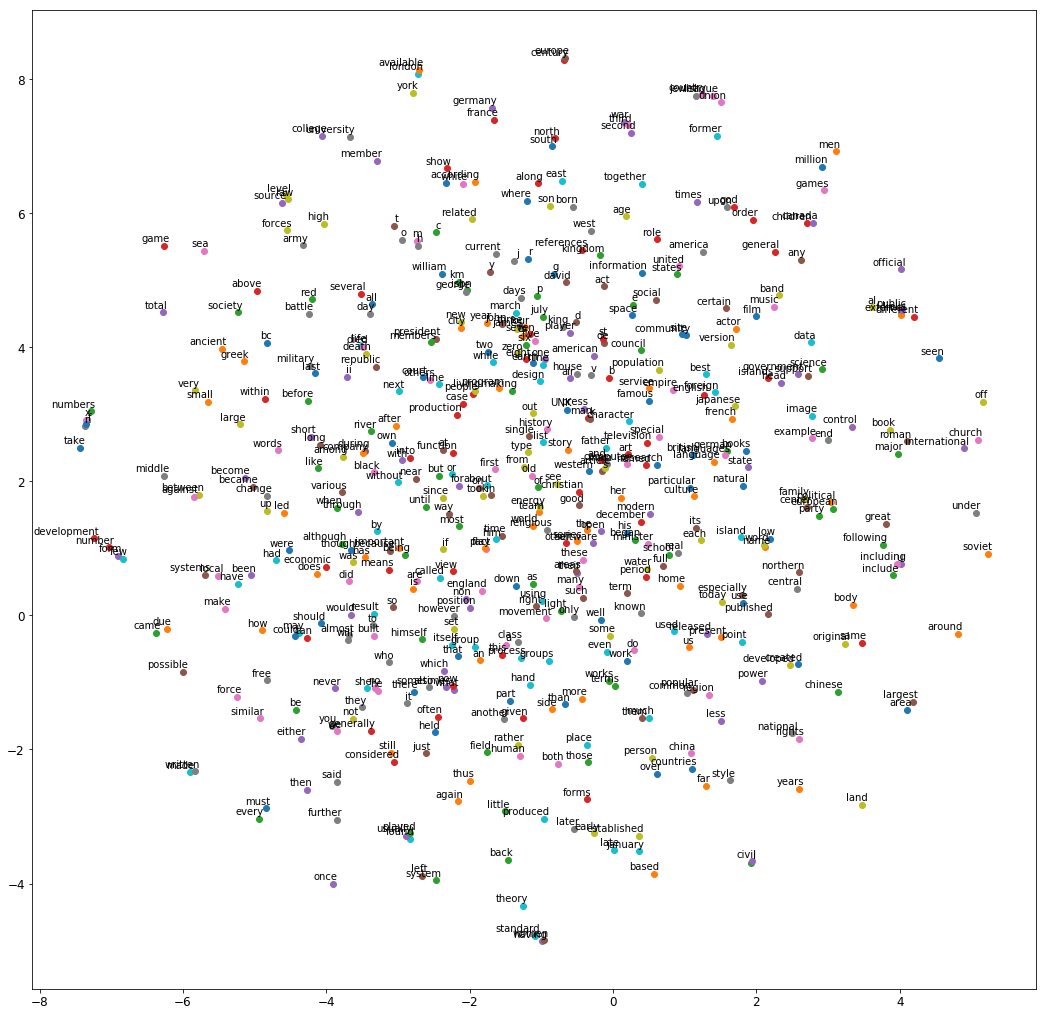

In [342]:
from sklearn.manifold import TSNE

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
plot_only = 500
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only,:])
labels = [vocabulary[i] for i in range(plot_only)]
plot_with_labels(low_dim_embs, labels)

# Machine Translation

The `basic_rnn_seq2seq()` function creates a simple Encoder/Decoder model: it first runs an RNN to encode `encoder_inputs` into a state vector, then runs a decoder initialized with the last encoder state on `decoder_inputs`. Encoder and decoder use the same RNN cell type but they don't share parameters.

In [358]:
import tensorflow as tf
reset_graph()

n_steps = 50
n_neurons = 200
n_layers = 3
num_encoder_symbols = 20000
num_decoder_symbols = 20000
embedding_size = 150
learning_rate = 0.01

X = tf.placeholder(tf.int32, [None, n_steps]) # English sentences
Y = tf.placeholder(tf.int32, [None, n_steps]) # French translations
W = tf.placeholder(tf.float32, [None, n_steps - 1, 1])
Y_input = Y[:, :-1]
Y_target = Y[:, 1:]

encoder_inputs = tf.unstack(tf.transpose(X)) # list of 1D tensors
decoder_inputs = tf.unstack(tf.transpose(Y_input)) # list of 1D tensors

lstm_cells = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons)
              for layer in range(n_layers)]
cell = tf.contrib.rnn.MultiRNNCell(lstm_cells)

output_seqs, states = tf.contrib.legacy_seq2seq.embedding_rnn_seq2seq(
    encoder_inputs,
    decoder_inputs,
    cell,
    num_encoder_symbols,
    num_decoder_symbols,
    embedding_size)

logits = tf.transpose(tf.unstack(output_seqs), perm=[1, 0, 2])

In [359]:
logits_flat = tf.reshape(logits, [-1, num_decoder_symbols])
Y_target_flat = tf.reshape(Y_target, [-1])
W_flat = tf.reshape(W, [-1])
xentropy = W_flat * tf.nn.sparse_softmax_cross_entropy_with_logits(labels=Y_target_flat, logits=logits_flat)
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

# Exercise solutions

**Coming soon**